## Loading Packages

In [3]:
from Foresight import *
set_seed(42)
import matplotlib.ticker as plticker

### Ensuring that training is done on GPU if available

In [8]:
device = 'cpu'

if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
    
    if torch.cuda.device_count() > 1:
        print("Parallel Available")
        parallel=True
        
    else:
        parallel=False
        
else:
    print("No GPU available!")
    parallel=False

No GPU available!


## Loading data

In [9]:
path = "../Data/"
universe_dict = universe_select(path, "MTL")

## Setting run conditions

In [10]:
use_lg_returns = False
auto_regressive = False
use_PCA = True
feat_spawn = False
saving = False
loading = False
forecast_length = 5

if auto_regressive: assert (auto_regressive!=use_PCA)

## Preprocessing

In [11]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# # Generating the dataset
# Have the metal of interest as the first entry in target_col
if use_lg_returns:
    # Lg Returns Only
    df_full = generate_dataset(universe_dict, lg_only=True, price_only=False)
    target_col = ["cu_lme", "al_lme", "sn_lme", "pb_lme", "ni_lme"]
    
else:
    # Price Only
    df_full = generate_dataset(universe_dict, lg_only=False, price_only=True)
    target_col = ["price_cu_lme", "price_al_lme", "price_sn_lme", "price_pb_lme", "price_ni_lme"]

if auto_regressive:
    df_full = df_full[target_col]
    
if feat_spawn:
    df_full = feature_spawn(df_full)

Included Instrument:
al_shfe
al_lme
al_comex_p
Rows removed: 1
al_comex_s
al_lme_s
yuan
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci
sn_lme
pb_lme
ni_lme


### Visualising the dataset

In [12]:
df_full.head(5)
# df_full.tail(5)

# Visualise the plots if desired
# visualise_df(df_full)

,price_al_shfe,price_al_lme,price_al_comex_p,price_al_comex_s,price_al_lme_s,price_yuan,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci,price_sn_lme,price_pb_lme,price_ni_lme
date,,,,,,,,,,,,,,,,,,,,
2014-06-04,13270.0,1812.75,2189.75,13403.0,5170375.0,6.2494,49570.0,6834.0,3.0935,16395.0,552.09,2.789,959.0,0.0355,12.08,121.48,645.9893,23225.0,2103.0,19025.0
2014-06-05,13235.0,1824.25,2201.00,13852.0,5160575.0,6.2548,49520.0,6803.0,3.0910,16440.0,550.66,2.789,977.0,0.0355,11.68,122.21,646.6336,23245.0,2109.0,19030.0
2014-06-06,13280.0,1856.75,2222.25,14276.0,5152975.0,6.2498,49550.0,6696.0,3.0530,16323.0,549.03,2.789,989.0,0.0330,10.73,122.88,646.6281,23195.0,2109.0,18875.0
2014-06-09,13385.0,1886.00,2257.00,14876.0,5146525.0,6.2397,48720.0,6688.5,3.0455,16183.0,549.65,2.783,999.0,0.0355,11.15,124.67,651.2814,23295.0,2141.0,18905.0
2014-06-10,13455.0,1865.50,2250.75,15138.0,5140000.0,6.2240,48420.0,6710.0,3.0550,16320.0,553.49,2.789,1004.0,0.0406,10.99,125.38,648.0516,22865.0,2140.0,18775.0


### Normalizing the dataset

In [13]:
# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[target_col]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = data_y[forecast_length:, :]

### PCA

In [14]:
# Reducing the dataset to containing a threshold amount of variance
if use_PCA:
    n_dim = dimension_selector(data_X, thresh=0.95)
    data_X = dimension_reduce(data_X, n_dim)

Number of dimensions: 7
Explained Variance Sum: 0.952
Explained Variance Composition [0.4731094  0.28411277 0.08974061 0.04456996 0.02808504 0.01800107
 0.01438797]


### Slicing Series into Windows

In [15]:
# The input size of each time series window
series_length = 132
  
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=1.0)

# [Number of series, time series length, number of features]
print("Data X shape", data_X.shape,
      "\nData y shape", data_y.shape)

Data X shape (1178, 132, 7) 
Data y shape (1178, 5)


### Hyperparameters

In [16]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32

# Training Parameters
n_epochs = 1000
patience = 50
disp_freq= 20
fig_disp_freq= 20

# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 8
dense_hidden = 32
num_layers = 1
output_dim = data_y.shape[1]
dropout = 0

### Initialising the model

In [41]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim,
             dense_hidden=dense_hidden,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

if parallel:
    model = nn.DataParallel(model)
    print("Parallel Workflow\n")
    
model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 7 
hidden_dim 8
series_length 132 
batch_size 32
output_dim 5 
num_layers 1
data_X  (1051, 132, 7) 
data_y (1051, 5)


In [42]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

"""Do I need to declare a data explicitly in the dataset"""
learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=n_epochs,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=patience, 
                        scaler_data_X=scaler_data_X,
                        scaler_data_y=scaler_data_y)


# Splitting the data into the train, validation and test sets
learning.train_val_test()

Epoch: 0 Train: 4.77304 Val: 5.68727  Time: 1.538  Best Val: 5.68727


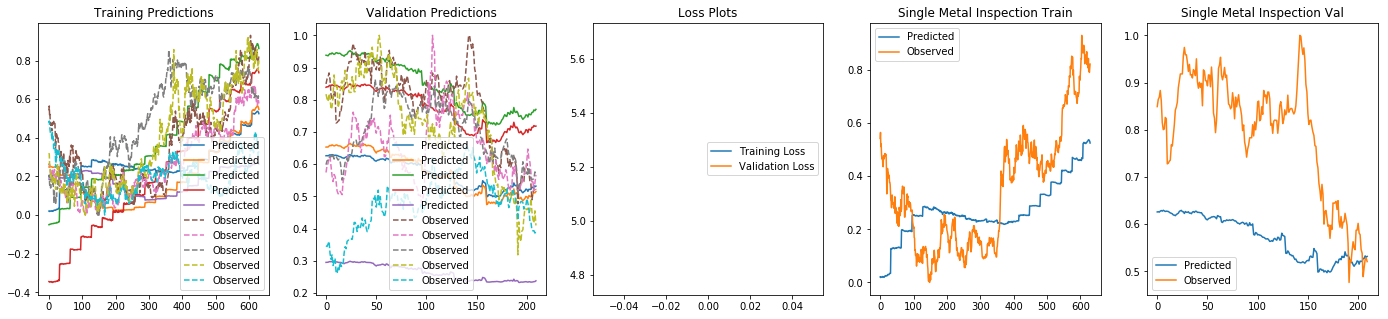

Epoch: 20 Train: 1.15341 Val: 1.89150  Time: 29.479  Best Val: 1.89150


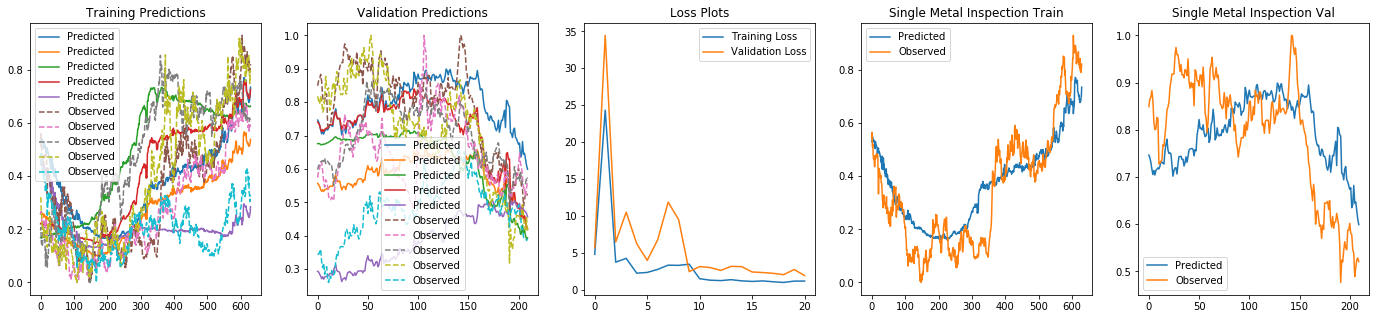

Epoch: 40 Train: 1.81566 Val: 6.11551  Time: 58.358  Best Val: 1.89150


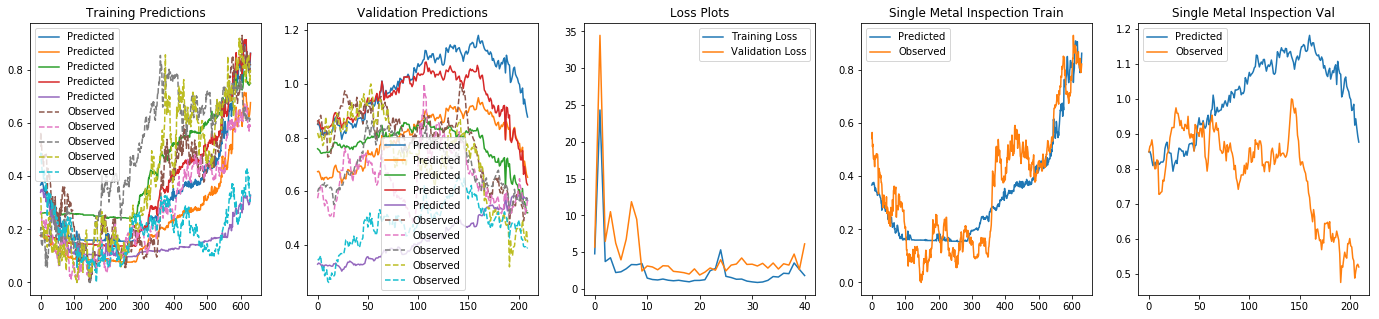

Epoch: 60 Train: 1.21328 Val: 2.92764  Time: 86.854  Best Val: 1.89150


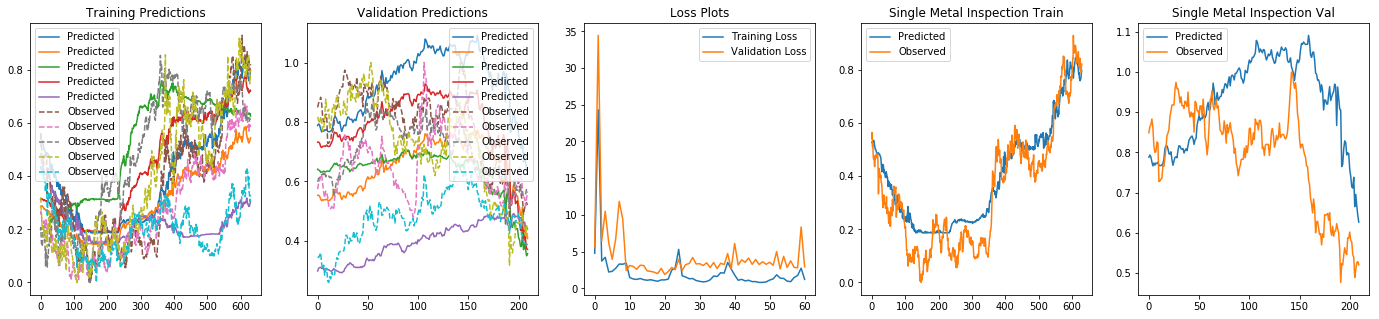

Early Stopping


In [43]:
# Allows for continious training by resetting the patience counter
# learning.n_epochs = 1000
learning.early.stop = False
learning.early.counter = 0
learning.training_wrapper()

### Evaluating on Test Data

In [44]:
# learning.val_loader = learning.test_loader
learning.evaluate(learning.best_model, learning.test_loader)

3.628728170530491

### Saving Model Object

In [13]:
model_name = "MTL_Full" + "_F" + str(forecast_length)

if saving:
    print("Saving")
    # Saving Pickle
    pickle.dump(learning, open("../Results/Pickles/MTL/" + model_name, 'wb'))
    # Saving Pth
    model_save(model, model_name, path="../Results/Pths/MTL/")

### Loading Example

#### Must be running on the same computational environment as the pickle was saved to load the pickle

In [7]:
if loading:
    print("Loading")
    # Input Name of Model to load
    model_load_name = "MV_MTL_Example_F132" 

    # Load Pickle
    learning = pickle.load(open("../Results/Pickles/MTL/" + model_load_name + ".pkl", 'rb'))

    # Loading Learning Object
    model = model_load(path="../Results/Pths/MTL/", device=device, model_name=model_load_name)

### Rescaling & Plotting

In [8]:
# Observed
train_true = learning.scaler_data_y.inverse_transform(learning.y_train.numpy())
val_true  = learning.scaler_data_y.inverse_transform(learning.y_val.numpy())
test_true  = learning.scaler_data_y.inverse_transform(learning.y_test.numpy())

# Predicted
train_pred = learning.scaler_data_y.inverse_transform(np.array(learning.train_predictions))
val_pred  = learning.scaler_data_y.inverse_transform(np.array(learning.val_predictions))
test_pred = learning.scaler_data_y.inverse_transform(np.array(learning.test_predictions))

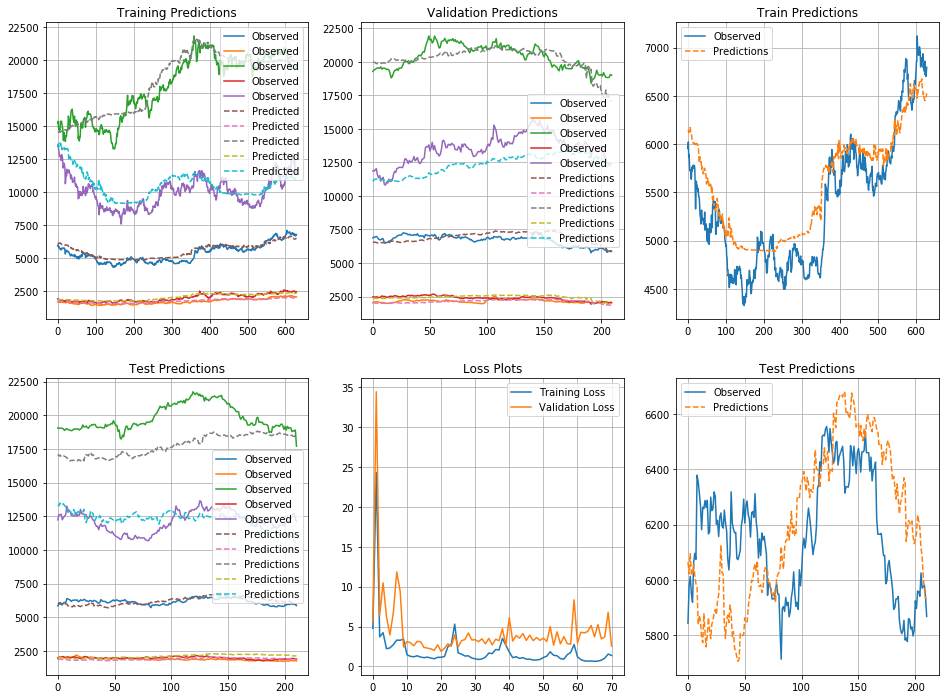

In [11]:
# Rescaling Example
fig, ax = plt.subplots(2, 3, figsize=(16, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, '--', label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, '--', label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, '--', label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()

ax[0, 2].grid()
ax[0, 2].set_title("Train Predictions")
ax[0, 2].plot(train_true[:, 0], label="Observed")
ax[0, 2].plot(train_pred[:, 0], '--', label="Predictions")
ax[0, 2].legend()

ax[1, 2].grid()
ax[1, 2].set_title("Test Predictions")
ax[1, 2].plot(test_true[:, 0], label="Observed")
ax[1, 2].plot(test_pred[:, 0], '--', label="Predictions")
ax[1, 2].legend()


if saving:
    print("Saving")
    plt.savefig("../Results/" + model_name + ".png")
    
plt.show()

### Evaluating Results

In [12]:
mse, mae, mde = evaluate(test_pred[:, :1], test_true[:, :1], log_ret=False)
print("Copper Price Metrics: ", 
      mse, mae, mde)

mse, mae, mde = evaluate(test_pred[:, :], test_true[:, :], log_ret=False)
print("Complex Price Metrics: ", 
      mse, mae, mde)

Copper Price Metrics:  79190.35793516658 242.53348778407155 0.5142857142857142
Complex Price Metrics:  1208505.0391360992 663.5987643016035 0.4780952380952381


### Naive Example

In [21]:
test_naive = test_true[:-forecast_length, :]
mse_naive, mae_naive, mde_naive = evaluate(test_naive, test_true[forecast_length:], log_ret=False)
print("Naive: ", mse_naive, mae_naive, mde_naive)

Naive:  256191.1 308.42654 0.4438095238095238


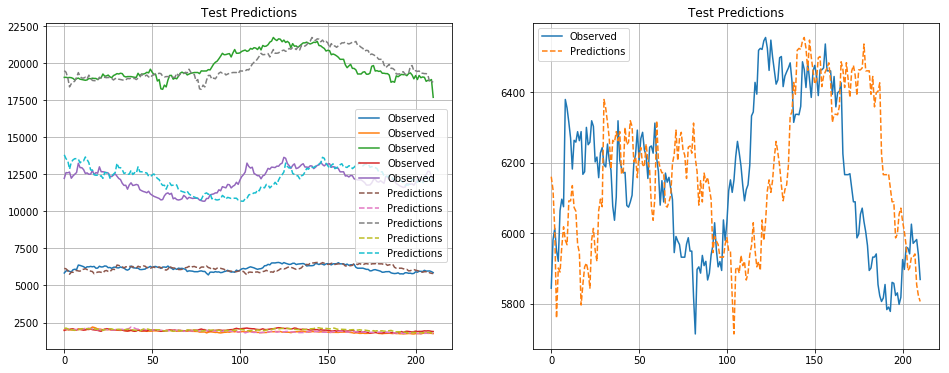

In [22]:
# Rescaling Example
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


ax[0].grid()
ax[0].set_title("Test Predictions")
ax[0].plot(test_true[forecast_length:], label="Observed")
ax[0].plot(test_naive, '--', label="Predictions")
ax[0].legend()


ax[1].grid()
ax[1].set_title("Test Predictions")
ax[1].plot(test_true[forecast_length:][:,0][:], label="Observed")
ax[1].plot(test_naive[:,0], '--', label="Predictions")
ax[1].legend()

if saving:
    plt.savefig(path + "MTL_Naive_F" + str(forecast_length) + ".png")
    
plt.show()

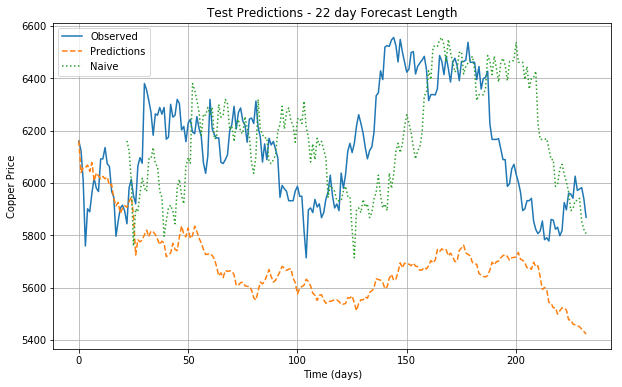

In [23]:
x = np.array(range(forecast_length, len(test_true)))

plt.figure(figsize=(10, 6))
plt.grid()
plt.ylabel("Copper Price")
plt.xlabel("Time (days)")
plt.title("Test Predictions - %i day Forecast Length" %forecast_length)
plt.plot(test_true[:, 0], label="Observed")
plt.plot(test_pred[:, 0], '--', label="Predictions")
plt.plot(x, test_naive[:, 0], ':', label="Naive")
plt.legend()

if saving:
    plt.savefig("../Results/" + model_name + ".png")
    
plt.show()

In [18]:
learning_5 = pickle.load(open("../Results/Pickles/MTL/Multivariate/MTL_Full_F5", 'rb'))
learning_22 = pickle.load(open("../Results/Pickles/MTL/Multivariate/MTL_Full_F22", 'rb'))
learning_66 = pickle.load(open("../Results/Pickles/MTL/Multivariate/MTL_Full_F66", 'rb'))
learning_132 = pickle.load(open("../Results/Pickles/MTL/Multivariate/MTL_Full_F132", 'rb'))

In [19]:
test_pred_5 = learning_5.scaler_data_y.inverse_transform(np.array(learning_5.test_predictions))
test_pred_22 = learning_22.scaler_data_y.inverse_transform(np.array(learning_22.test_predictions))
test_pred_66 = learning_66.scaler_data_y.inverse_transform(np.array(learning_66.test_predictions))
test_pred_132 = learning_132.scaler_data_y.inverse_transform(np.array(learning_132.test_predictions))

test_true_5  = learning_5.scaler_data_y.inverse_transform(learning_5.y_test.numpy())
test_true_22  = learning_22.scaler_data_y.inverse_transform(learning_22.y_test.numpy())
test_true_66  = learning_66.scaler_data_y.inverse_transform(learning_66.y_test.numpy())
test_true_132  = learning_132.scaler_data_y.inverse_transform(learning_132.y_test.numpy())

### Visual comparions on MTL and Naive

In [20]:
vals = df_target['price_cu_lme'].values
start5 = len(vals) - len(test_true_5)
start22 = len(vals) - len(test_true_22)
start66 = len(vals) - len(test_true_66)
start132 = len(vals) - len(test_true_132)

### Naive

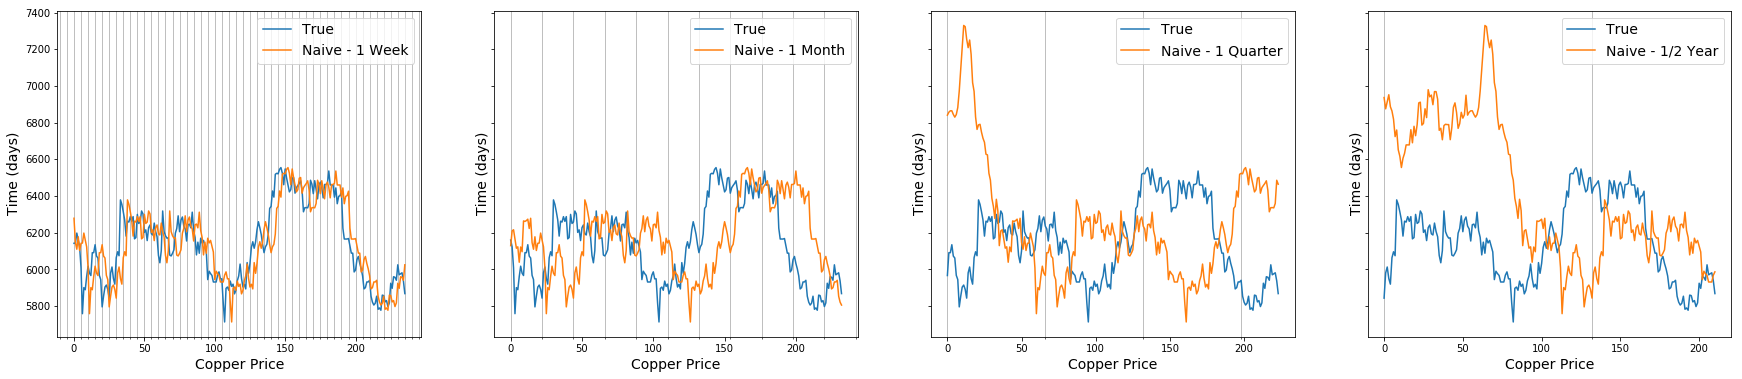

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6), sharey=True)

ax[0].plot(vals[start5:], label='True')
ax[1].plot(vals[start22:], label='True')
ax[2].plot(vals[start66:], label='True')
ax[3].plot(vals[start132:], label='True')

ax[0].plot(vals[start5-5:-5], label='Naive - 1 Week')
ax[1].plot(vals[start22-22:-22], label='Naive - 1 Month')
ax[2].plot(vals[start66-66:-66], label='Naive - 1 Quarter')
ax[3].plot(vals[start132-132:-132], label='Naive - 1/2 Year')

#Spacing between each line
loc5 = plticker.MultipleLocator(base=5)
loc22 = plticker.MultipleLocator(base=22)
loc66 = plticker.MultipleLocator(base=66)
loc132 = plticker.MultipleLocator(base=132)

ax[0].grid(which='minor')
ax[0].xaxis.set_minor_locator(loc5)

ax[1].grid(which='minor')
ax[1].xaxis.set_minor_locator(loc22)

ax[2].grid(which='minor')
ax[2].xaxis.set_minor_locator(loc66)

ax[3].grid(which='minor')
ax[3].xaxis.set_minor_locator(loc132)

for axes in ax:
    axes.legend(prop={'size': 14})
    axes.set_xlabel('Copper Price', fontsize=14)
    axes.set_ylabel('Time (days)', fontsize=14)

if saving:
    plt.savefig("../Results/Plots/Naive_Forecast_Comp")
    plt.show()

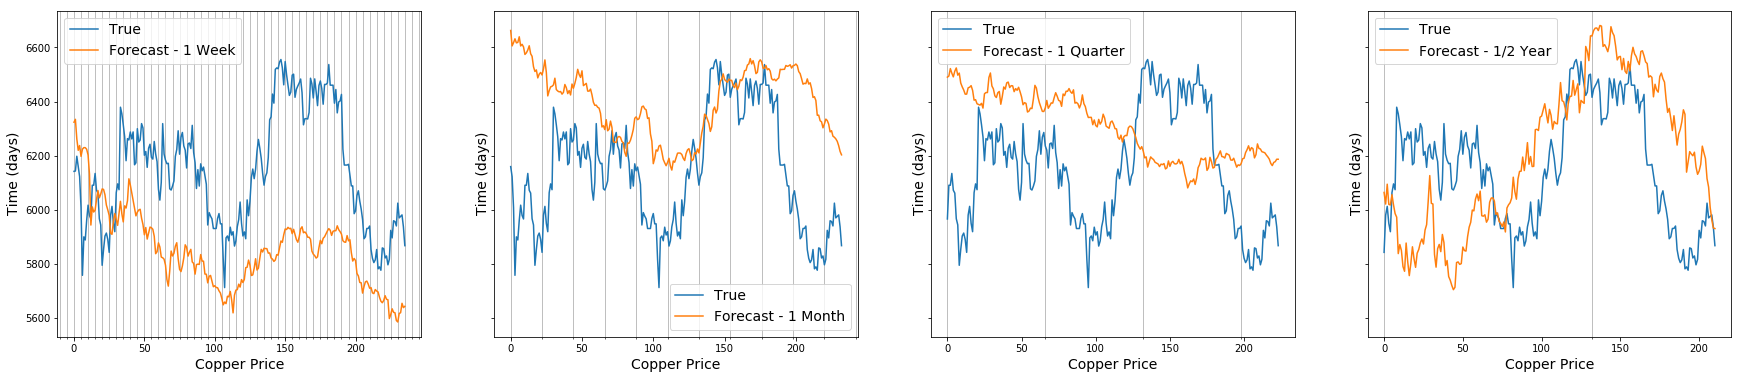

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6), sharey=True)

ax[0].plot(test_true_5[:, 0], label='True')
ax[1].plot(test_true_22[:, 0], label='True')
ax[2].plot(test_true_66[:, 0], label='True')
ax[3].plot(test_true_132[:, 0], label='True')

ax[0].plot(test_pred_5[:, 0], label='Forecast - 1 Week')
ax[1].plot(test_pred_22[:, 0], label='Forecast - 1 Month')
ax[2].plot(test_pred_66[:, 0], label='Forecast - 1 Quarter')
ax[3].plot(test_pred_132[:, 0], label='Forecast - 1/2 Year')

#Spacing between each line
loc5 = plticker.MultipleLocator(base=5)
loc22 = plticker.MultipleLocator(base=22)
loc66 = plticker.MultipleLocator(base=66)
loc132 = plticker.MultipleLocator(base=132)

ax[0].grid(which='minor')
ax[0].xaxis.set_minor_locator(loc5)

ax[1].grid(which='minor')
ax[1].xaxis.set_minor_locator(loc22)

ax[2].grid(which='minor')
ax[2].xaxis.set_minor_locator(loc66)

ax[3].grid(which='minor')
ax[3].xaxis.set_minor_locator(loc132)

for axes in ax:
    axes.legend(prop={'size': 14})
    axes.set_xlabel('Copper Price', fontsize=14)
    axes.set_ylabel('Time (days)', fontsize=14)

if saving:
    plt.savefig("../Results/Plots/MTL_Forecast_Comp", transparent=True)

plt.show()